In [1]:
import numpy as np
import tensorflow as tf

In [11]:
#datagen = tf.keras.preprocessing.image.ImageDataGenerator(
#    featurewise_center = True,
#    samplewise_center = True,
#    featurewise_std_normalization = True,
#    samplewise_std_normalization = True
#)
datagen = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255)

train_datagen = datagen.flow_from_directory(
    'dataset_augmented/train',
    target_size=(160, 160),
    batch_size=32,
    class_mode='sparse'
)

test_datagen = datagen.flow_from_directory(
    'dataset_augmented/test',
    target_size=(160, 160),
    batch_size=32,
    class_mode='sparse'
)

Found 25842 images belonging to 7 classes.
Found 6047 images belonging to 7 classes.


In [12]:
def mish(inputs):
    x = tf.nn.softplus(inputs)
    x = tf.nn.tanh(x)
    x = tf.multiply(x, inputs)
    return x

In [27]:
def mish_shallow():
    model = tf.keras.Sequential([
        tf.keras.layers.Input(shape=(160, 160, 3)),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(64, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Dropout(0.1),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(128, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.Conv2D(256, kernel_size=(3, 3), activation=mish, padding='same'),
        tf.keras.layers.MaxPool2D(pool_size=(2, 2), strides=(2, 2)),
        tf.keras.layers.Dropout(0.2),
        #tf.keras.layers.BatchNormalization(),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(512, activation=mish),
        tf.keras.layers.Dense(1024, activation=mish, kernel_regularizer=tf.keras.regularizers.l1_l2(0.0001)),
        #tf.keras.layers.Dense(1024, activation=mish, kernel_regularizer=tf.keras.regularizers.l1_l2(0.001)),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(7, activation='softmax')
    ])

    model.summary()

    return model

In [28]:
def scheduler(epoch):
    if epoch < 10:
        return 0.001
    elif epoch < 140:
        return 0.0001
    elif epoch < 200:
        return 0.00006
    elif epoch < 300:
        return 0.00003

scheduler_callback = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [29]:
model = mish_shallow()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=scheduler(0)),
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
)

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_36 (Conv2D)          (None, 160, 160, 64)      1792      
                                                                 
 conv2d_37 (Conv2D)          (None, 160, 160, 64)      36928     
                                                                 
 max_pooling2d_16 (MaxPoolin  (None, 80, 80, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_38 (Conv2D)          (None, 80, 80, 128)       73856     
                                                                 
 conv2d_39 (Conv2D)          (None, 80, 80, 128)       147584    
                                                                 
 max_pooling2d_17 (MaxPoolin  (None, 40, 40, 128)      0         
 g2D)                                                 

In [30]:
with tf.device('/gpu:0'):
    history = model.fit(train_datagen, epochs=300, batch_size=32, validation_data=test_datagen, verbose=1, steps_per_epoch=16, validation_steps=64, callbacks=[scheduler_callback])

Epoch 1/300
16/16 [==============================] - 8s 391ms/step - loss: 8.4063 - accuracy: 0.1348 - val_loss: 6.6463 - val_accuracy: 0.0220 - lr: 0.0010
Epoch 2/300
16/16 [==============================] - 5s 352ms/step - loss: 5.8356 - accuracy: 0.1582 - val_loss: 5.3163 - val_accuracy: 0.0771 - lr: 0.0010
Epoch 3/300
16/16 [==============================] - 5s 342ms/step - loss: 4.6648 - accuracy: 0.1445 - val_loss: 3.8859 - val_accuracy: 0.0938 - lr: 0.0010
Epoch 4/300
16/16 [==============================] - 5s 345ms/step - loss: 3.7868 - accuracy: 0.1816 - val_loss: 3.7792 - val_accuracy: 0.0415 - lr: 0.0010
Epoch 5/300
16/16 [==============================] - 5s 344ms/step - loss: 3.1982 - accuracy: 0.1816 - val_loss: 3.3450 - val_accuracy: 0.2495 - lr: 0.0010
Epoch 6/300
16/16 [==============================] - 5s 344ms/step - loss: 2.8673 - accuracy: 0.1934 - val_loss: 2.8170 - val_accuracy: 0.1304 - lr: 0.0010
Epoch 7/300
16/16 [==============================] - 5s 344ms/st

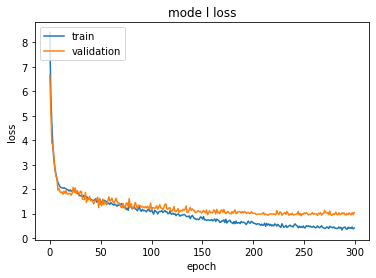

In [31]:
import matplotlib.pyplot as plt

# Save Train result
fig2 = plt.gcf()
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('mode l loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig2.savefig('history/loss16_new_augmen.jpg')

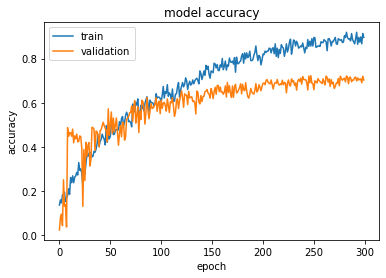

In [32]:
fig1 = plt.gcf()
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

fig1.savefig('history/accuracy16_new_augmen.jpg')

In [33]:
def myprint(s):
    with open('history/modelsummary16_new_augmen.txt','a') as f:
        print(s, file=f)

model.summary(print_fn=myprint)

In [37]:
# Model Validation
eval_hist_train = model.evaluate(train_datagen)
eval_hist_test = model.evaluate(test_datagen)

189/189 [==============================] - 9s 47ms/step - loss: 1.0177 - accuracy: 0.7070


In [38]:
accuracy_eval_train = eval_hist_train[1]
accuracy_eval_test = eval_hist_test[1]

In [39]:
model.save_weights("utils/demo_weight.h5")